# Review Classifier 

----
This notebook is used to create an app that can categorize reviews.

Reviews fall across two categories.
1. `Positive` Review, 
2. `Negative` Review.



# installing needed libraries.


In [ ]:
! pip install datasets
! pip install evaluate
! pip install transformers
! pip install ohmeow-blurr
! pip install onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47


# Importing important libraries.

In [ ]:
import pandas as pd
import numpy as np
from fastai.text.all import *
import scipy
import evaluate
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
torch.cuda.empty_cache()


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/nlp/amazon-review.csv'

In [ ]:
df = pd.read_csv(path)

# Exploratory Data Analysis

In [ ]:
df.head()

,Review,Label
0,Length of battery life and remote fail often! I dependability is not there!\n4 purchased 3 are in unreliable,0
1,"Its nice, easy to use but the batteries die in a couple of days. Not useful if I have to constantly put new batteries in. It takes 3 or 4 batteries, too expensive to use. Wish I could return it.",0
2,"This is a poorly designed and functioning product, and would not recommend it to friends or family. The bracket is difficult to secure to wall using nuts and screws provided in kit. The illumination is not adequate to light a normal sized painting. Changing the batteries is not easily accomplished without taking down the paint and heavy frame.",0
3,THE LIGHT IS JUST WRIGHT AND THE CONTROL MAKES IT EASY TO TURN ON.,1
4,"Great instructions, made for an easy install. Really like that there are 3 lighting effects to choose from. Remote works perfectly and has different timers- don't want to waste batteries! Great buy. I would purchase again.",1


In [ ]:
df['labels'] = df['Label']

In [ ]:
df = df.drop(columns=['Label'])

In [ ]:
df.shape

(1220, 2)

In [ ]:
df.isnull().sum()

Review    13
labels     0
dtype: int64

In [ ]:
df[df['Review'].isnull()]

,Review,labels
79,NaN,1
80,NaN,1
347,NaN,1
412,NaN,1
475,NaN,1
522,NaN,1
549,NaN,1
770,NaN,1
1048,NaN,1
1100,NaN,1


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(1207, 2)

In [ ]:
token = Tokenizer(SpacyTokenizer)

In [ ]:
df= Dataset.from_pandas(df)

In [ ]:
df

Dataset({
    features: ['Review', 'labels', '__index_level_0__'],
    num_rows: 1207
})

In [ ]:
df[0]

{'Review': 'Length of battery life and remote fail often! I dependability is not there!\n4 purchased 3 are in unreliable',
 'labels': 0,
 '__index_level_0__': 0}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')#distilbert-base-uncased-finetuned-sst-2-english,'ProsusAI/finbert'

# Blurr

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *


/usr/local/lib/python3.8/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [ ]:
model_cls = AutoModelForSequenceClassification
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'

config = AutoConfig.from_pretrained(model_name)
config.num_labels = 2

hf_arc,hf_config,hf_tokenizer,hf_model = get_hf_objects(model_name,model_cls=model_cls,config=config)


In [ ]:
blocks = (TextBlock(hf_arc,hf_config,hf_tokenizer,hf_model),CategoryBlock)

In [ ]:
dblock = DataBlock(blocks = blocks,get_x=ColReader('Review'),get_y=ColReader('labels'),splitter=RandomSplitter(valid_pct = .1,seed =42))

In [ ]:
dls = dblock.dataloaders(df,bs=32)

In [ ]:
dls.show_batch(dataloaders =dls,max_n=3)

,text,target
0,"i had my doubts about these... i knew that the paintings in corner of my den needed some lighting, but the thought of having a cord hanging down the wall was untenable to me. cutting in two outlets on the wall behind the paintings could be easily accomplished, but if the paintings ever came down, the outlets would have had to be removed. this installation remains a possibility. in the meantime, these lights serve to reinforce the notion that this corner needs lighting. they were simple to install, taking less than 10 minutes each. the lighting modes offer more variety than most plug in lights, and the dimming feature allows you to both extend battery life while adjusting to the lighting needs of the moment. the timer feature is also useful for extending battery life. it turns off what i forgot. there is a clever little bubble level integral to the mounting bracket that made the installation that much easier. the only adjustment that i had to make was in the field of light coming from the unit. the lights throw a full 180 degrees of light, which resulted for me in light shining above the paintings and frames and onto the wall. i remedied this by placing electrician's tape across the upper section of the lens of the light. depending on the size of your piece, you may want to similarly adjust the range of lighting. this modification does not show in the room. i found that mounting it as close to the frame as possible was the best placement for the light. mounting it above the frame resulted in highlighting the space between the frame and the lights'base. to sum up, the light is inexpensive, easily installed, versatile, and effective. i can enthusiastically recommend it to anyone who finds himself wanting to light up a framed piece of artwork without undertaking a small home wiring project.",1
1,"i'll admit i had really low expectations for this. but i was simply looking for a way to highlight a large piece of wall art without needing to deal with a cord to hide. this light is awesome in appearance, and although it's plastic, it's not flimsy. the gold leans more towards rose gold, but hey.... it's gold and that's a fun theme i have in this room. it has a low and high light output setting, which is good because i'm not a fan of the bright white led bulbs ( even the high setting isn't obnoxiously white ). an added bonus i didn't even know about is that it has timeframes you can set it to stay on - 30, 60, 90 or 120 minutes. this is great for me so i don't have to wonder if i forgot to turn it off or not. i probably should have dove into the mounting instructions more, because it took me a couple tries to get it on correctly. but the mounting bracket even has a built in "" level "" for easy straight mounting. overall i'm extremely happy with this purchase!",1
2,"i ordered this light to go over a frame that has a gold edge around the matting, however the only part that was gold on this light was the pivot arm. the majority of the light fixture is actually copper in color, which won ’ t work with my frame so i am returning the light. i did like the concept of being able to choose warm or cool lighting for my picture and also being able to pivot the aim of the light but the light is not bright enough for the color tone to matter. it only lit the very top part of the picture. another thing i discovered is that the majority of this light is plastic. i thought when the description said metal and plastic, that the lens over the led bulbs would be plastic and the rest would be metal when in fact the only part that is metal is the gold pivot arm. all other parts are plastic. even with its shortcomings, i might have kept the light had it actually been entirely gold as stated in the description. shiny copper with a small section of gold did not look right together in the light and looked even worse when i put it above the frame that also had gold accents. very disappointed!",0


# Model Train and Evaluate

In [ ]:
model = BaseModelWrapper(hf_model)

In [ ]:
learner = Learner(
    dls,
    model,
    opt_func = partial(OptimWrapper, opt = torch.optim.AdamW),
    loss_func = PreCalculatedCrossEntropyLoss(),
    metrics = [accuracy],
    cbs = [BaseModelCallback],
    splitter = blurr_splitter
).to_fp16()

In [ ]:
model

BaseModelWrapper(
  (hf_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (f

In [ ]:
learner.freeze

<bound method Learner.freeze of <fastai.learner.Learner object at 0x7f787e66a850>>

SuggestedLRs(minimum=0.00036307806149125097, steep=6.309573450380412e-07)

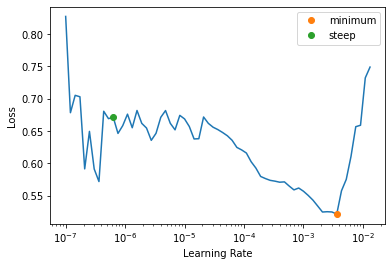

In [ ]:
learner.lr_find(suggest_funcs = [minimum,steep])

In [ ]:
learner.fit_one_cycle(2,6.31e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.690743,0.646254,0.858333,00:06
1,0.644103,0.632146,0.858333,00:04


In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.00019054606673307717, valley=0.00013182566908653826)

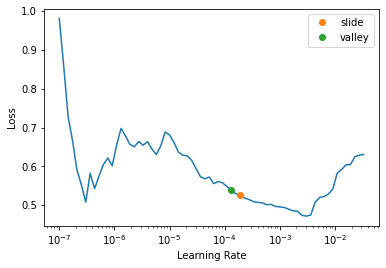

In [ ]:
learner.lr_find(suggest_funcs = [slide,valley])

In [ ]:
learner.fit_one_cycle(5,slice(1.9e-4,3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.376534,0.358025,0.816667,00:03
1,0.377783,0.398984,0.825000,00:04
2,0.279496,0.347377,0.883333,00:04
3,0.210287,0.387096,0.875000,00:03
4,0.135061,0.334733,0.883333,00:03


In [ ]:
learner.save('/content/drive/MyDrive/Colab Notebooks/nlp/learner2')
learner.export('/content/drive/MyDrive/Colab Notebooks/nlp/learner2.pkl')

In [ ]:
model = load_learner('/content/drive/MyDrive/Colab Notebooks/nlp/learner2.pkl')

In [ ]:
model.blurr_predict("If you have the money and feel like splurging and like the color aqua, then this is a nice buy. The mouse has a soft cover and it's easy to store. It's easy to set up too. It has a very intuitive design. I bought this to match my aqua Surface keyboard and they match really well. Very aesthetically pleasing. If only I had the aqua pen.")

[{'label': '1',
  'score': 0.9507913589477539,
  'class_index': 1,
  'class_labels': [0, 1],
  'probs': [0.0492086336016655, 0.9507913589477539]}]

In [ ]:
model.blurr_predict("Bought a new Surface mouse because the one I bought with the Surface computer suddenly stopped working. The new one does not work as well and I followed all the directions on line for reprogramming. Very frustrating. I will need to take it in to Best Buy for the Geek Squad to work on it. I understand the sudden inability to work has to do with a Micosoft update for Windows 10.")

[{'label': '0',
  'score': 0.9864550828933716,
  'class_index': 0,
  'class_labels': [0, 1],
  'probs': [0.9864550828933716, 0.013544936664402485]}]

In [ ]:
model.blurr_predict("was not new had a big rust mark was not wrapped properly not working")

[{'label': '0',
  'score': 0.9825116991996765,
  'class_index': 0,
  'class_labels': [0, 1],
  'probs': [0.9825116991996765, 0.017488375306129456]}]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 660.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have

In [ ]:
splited_data['test']

Dataset({
    features: ['Review', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 121
})

In [ ]:
def measure_accuracy(data,label):
  pred = [int(model.blurr_predict(x)[0]['label']) for x in data]
  
  cnt = 1
  for i in range(len(pred)):
    if pred[i] == label[i]:
      cnt+=1

  
  print(f'Accuracy: {cnt*100/len(pred)}')




In [ ]:
measure_accuracy(splited_data['test']['Review'],splited_data['test']['labels'])

Accuracy: 99.17355371900827


In [ ]:
classifier = model.model.hf_model.eval()


# Model Compression by `ONNX`

In [ ]:
import torch
from onnxruntime.quantization import quantize_dynamic,QuantType

In [ ]:
torch.onnx.export(
    classifier,
    torch.LongTensor([[0]*512]),
    "/content/drive/MyDrive/Colab Notebooks/nlp/classifier.onnx",
    input_names = ['input_ids'],
    output_names=['output'],
    opset_version=13,
    dynamic_axes={
        'input_ids':{0:'batch_size',1:'sequence_len'},
        'output':{0:'batch_size'}
    }
)

/usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py:218: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [ ]:
onnx_path = "/content/drive/MyDrive/Colab Notebooks/nlp/classifier.onnx"
quantized_onnx_path = "/content/drive/MyDrive/Colab Notebooks/nlp/classifier_quantized.onnx"

In [ ]:
quantize_dynamic(
    onnx_path,
    quantized_onnx_path,
    weight_type = QuantType.QUInt8
)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM